Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

# Non-regression tests towards implementing P3M gravity

## Set up the environment and parameters

In [1]:
# pyright: reportWildcardImportFromLibrary=false
from wip3m import *

In [2]:
workdir = ROOT_PATH + "results/"
output_path = OUTPUT_PATH

L = 32  # Box size in Mpc/h
N = 64  # Density grid size
Np = 32  # Number of dark matter particles per spatial dimension
Npm = 64  # PM grid size
n_Tiles = 8  # Make sure Npm/n_Tiles >= 6

go_beyond_Nyquist_ss = True  # for the summary statistics

force = True
force_hard = True
run_id = "notebook1"

# Good set of parameters for the force diagnostic
# nPairsForceDiagnostic = 5
# nBinsForceDiagnostic = 30
# maxTrialsForceDiagnostic = int(2e9)

# Faster force diagnostic
nPairsForceDiagnostic = 3
nBinsForceDiagnostic = 20
maxTrialsForceDiagnostic = int(1e8)

# Simulation parameters
nsteps_pm = 50
nsteps_cola1 = 10
nsteps_cola2 = 3
nsteps_spm = 50
nsteps_p3m = 50

In principle nothing needs to be changed below this cell.

In [3]:
# Automatic reloading of modules
%load_ext autoreload
%autoreload 2

from os.path import isfile
from pathlib import Path
import numpy as np

from pysbmy.power import PowerSpectrum
from pysbmy.fft import FourierGrid, read_FourierGrid
from pysbmy.field import read_field
from pysbmy.correlations import get_autocorrelation

from wip3m.tools import get_k_max, generate_sim_params, generate_white_noise_Field
from wip3m.params import params_planck_kmax_missing, cosmo_small_to_full_dict, z2a, BASELINE_SEEDPHASE
from wip3m.plot_utils import *  # type: ignore

In [ ]:
corner = -L / 2.0
RedshiftLPT = 19.0
RedshiftFCs = 0.0
ai = z2a(RedshiftLPT)
af = z2a(RedshiftFCs)
k_max = get_k_max(L, N)  # k_max in h/Mpc
print(f"k_max = {k_max}")
cosmo = params_planck_kmax_missing.copy()
cosmo["k_max"] = k_max

TimeStepDistribution_pm = 0
TimeStepDistribution_cola1 = 0
TimeStepDistribution_cola2 = 0
TimeStepDistribution_spm = 0
TimeStepDistribution_p3m = 0

wd = workdir + run_id + "/"
simdir = output_path + run_id + "/"
logdir = simdir + "logs/"
if force_hard:
    import shutil
    if Path(simdir).exists():
        shutil.rmtree(simdir)
    if Path(wd).exists():
        shutil.rmtree(wd)
Path(wd).mkdir(parents=True, exist_ok=True)
Path(logdir).mkdir(parents=True, exist_ok=True)

input_white_noise_file = simdir + "input_white_noise.h5"
input_seed_phase_file = simdir + "seed"
ICs_path = simdir + "initial_density.h5"
simpath = simdir

# Path to the input matter power spectrum (generated later)
input_power_file = simdir + "input_power.h5"

# Paths the the force diagnostic CSVs
OutputForceDiagnostic_pm = simdir + "force_diagnostic_pm.txt"
OutputForceDiagnostic_cola1 = simdir + "force_diagnostic_cola1.txt"
OutputForceDiagnostic_cola2 = simdir + "force_diagnostic_cola2.txt"
OutputForceDiagnostic_spm = simdir + "force_diagnostic_spm.txt"
OutputForceDiagnostic_p3m = simdir + "force_diagnostic_p3m.txt"

k_max = 10.883000000000001


### Generate the parameter files

The first preparatory step is to generate all the parameter files required for all the simulations.

To this end we use the `generate_sim_params` function defined in `params.py`.

In [ ]:
common_params = {
    "Np": Np,
    "N": N,
    "L": L,
    "corner0": corner,
    "corner1": corner,
    "corner2": corner,
    "h": cosmo["h"],
    "Omega_m": cosmo["Omega_m"],
    "Omega_b": cosmo["Omega_b"],
    "n_s": cosmo["n_s"],
    "sigma8": cosmo["sigma8"],
}

lpt_params = common_params.copy()
lpt_params["method"] = "lpt"
lpt_params["InputPowerSpectrum"] = input_power_file
lpt_params["ICsMode"] = 1
# 0 : the codes generates white noise, then initial conditions
# 1 : external white noise specified, the code multiplies by the power spectrum
# 2 : external initial conditions specified
lpt_params["InputWhiteNoise"] = input_white_noise_file

common_params_num = common_params.copy()
common_params_num["ai"] = ai
common_params_num["af"] = af
common_params_num["RedshiftLPT"] = RedshiftLPT
common_params_num["RedshiftFCs"] = RedshiftFCs
common_params_num["Npm"] = Npm
common_params_num["RunForceDiagnostic"] = True
common_params_num["nBinsForceDiagnostic"] = nBinsForceDiagnostic
common_params_num["nPairsForceDiagnostic"] = nPairsForceDiagnostic
common_params_num["maxTrialsForceDiagnostic"] = maxTrialsForceDiagnostic

pm_params = common_params_num.copy()
pm_params["method"] = "pm"
pm_params["TimeStepDistribution"] = TimeStepDistribution_pm
pm_params["nsteps"] = nsteps_pm
pm_params["OutputForceDiagnostic"] = OutputForceDiagnostic_pm

cola1_params = common_params_num.copy()
cola1_params["method"] = "cola"
cola1_params["TimeStepDistribution"] = TimeStepDistribution_cola1
cola1_params["nsteps"] = nsteps_cola1
cola1_params["OutputForceDiagnostic"] = OutputForceDiagnostic_cola1

cola2_params = common_params_num.copy()
cola2_params["method"] = "cola"
cola2_params["TimeStepDistribution"] = TimeStepDistribution_cola2
cola2_params["nsteps"] = nsteps_cola2
cola2_params["OutputForceDiagnostic"] = OutputForceDiagnostic_cola2

spm_params = common_params_num.copy()
spm_params["method"] = "spm"
spm_params["EvolutionMode"] = 5
spm_params["TimeStepDistribution"] = TimeStepDistribution_spm
spm_params["nsteps"] = nsteps_spm
spm_params["n_Tiles"] = n_Tiles
spm_params["OutputForceDiagnostic"] = OutputForceDiagnostic_spm

p3m_params = common_params_num.copy()
p3m_params["method"] = "p3m"
p3m_params["EvolutionMode"] = 4
p3m_params["TimeStepDistribution"] = TimeStepDistribution_p3m
p3m_params["nsteps"] = nsteps_p3m
p3m_params["n_Tiles"] = n_Tiles
p3m_params["OutputForceDiagnostic"] = OutputForceDiagnostic_p3m

[00:53:59|INFO      ]|(wip3m.tools) Generating parameter file...
[00:53:59|STATUS    ]|Writing parameter file in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook1/example_lpt.sbmy'...
[00:53:59|STATUS    ]|Writing parameter file in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook1/example_lpt.sbmy' done.
[00:53:59|INFO      ]|(wip3m.tools) Parameter file written to /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook1/example_lpt.sbmy
PM nsteps = 50:
[00:53:59|INFO      ]|(wip3m.tools) Time-stepping distribution file: /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook1/nsteps50_ts_pm.h5
[00:53:59|STATUS    ]|Write timestepping configuration in '/Users/hoellinger/Library/CloudStorage/Dropbox/

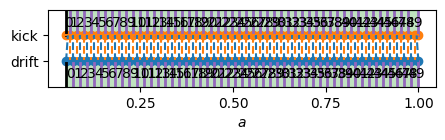

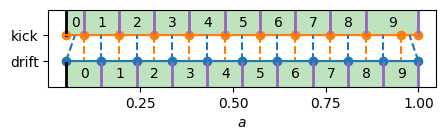

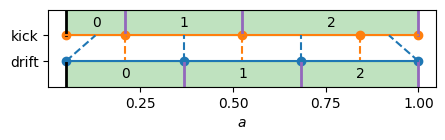

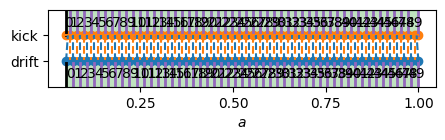

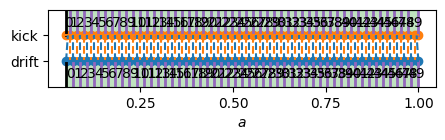

In [6]:
reset_plotting()  # Default style for Simbelmynë
generate_sim_params(lpt_params, ICs_path, wd, simdir, None, force)

print(f"PM nsteps = {nsteps_pm}:")
file_ext = f"nsteps{nsteps_pm}"  # "pm" is already in the filename
generate_sim_params(pm_params, ICs_path, wd, simdir, file_ext, force)

print(f"COLA1 nsteps = {nsteps_cola1}:")
file_ext = f"nsteps{nsteps_cola1}"  # "cola" is already in the filename
generate_sim_params(cola1_params, ICs_path, wd, simdir, file_ext, force)

print(f"COLA2 nsteps = {nsteps_cola2}:")
file_ext = f"nsteps{nsteps_cola2}"  # "cola" is already in the filename
generate_sim_params(cola2_params, ICs_path, wd, simdir, file_ext, force)

print(f"SPM nsteps = {nsteps_spm}:")
file_ext = f"nsteps{nsteps_spm}"  # "spm" is already in the filename
generate_sim_params(spm_params, ICs_path, wd, simdir, file_ext, force)

print(f"P3M nsteps = {nsteps_p3m}:")
file_ext = f"nsteps{nsteps_p3m}"  # "p3m" is already in the filename
generate_sim_params(p3m_params, ICs_path, wd, simdir, file_ext, force)
setup_plotting()  # Reset plotting style for this project

### Generate the initial phase

In [7]:
generate_white_noise_Field(
    L=L,
    size=N,
    corner=corner,
    seedphase=BASELINE_SEEDPHASE,
    fname_whitenoise=input_white_noise_file,
    seedname_whitenoise=input_seed_phase_file,
    force_phase=force,
)

### Generating the input power spectrum

The second preparatory step is to compute the initial power spectrum to be used in the simulations, given the cosmological parameters and prescription specified in ``params.py``. The power spectrum is saved in `input_power_file`.

In [8]:
# If cosmo["WhichSpectrum"] == "class", then classy is required.
if not isfile(input_power_file) or force:
    Pk = PowerSpectrum(L, L, L, N, N, N, cosmo_small_to_full_dict(cosmo))
    Pk.write(input_power_file)

[00:54:01|STATUS    ]|Setting up Fourier grid...
[00:54:01|STATUS    ]|Setting up Fourier grid done.
[00:54:01|STATUS    [00:54:01|STATUS    ]|Write power spectrum in data file '/Users/hoellinger/WIP3M/notebook1/input_power.h5'...
]|Computing normalization of the power spectrum...
[00:54:01|STATUS    ]|Computing normalization of the power spectrum done.
[00:54:01|STATUS    ]|Computing power spectrum...
[00:54:01|STATUS    ]|Computing power spectrum done.
[00:54:01|DIAGNOSTIC]==|L0=32, L1=32, L2=32
[00:54:01|DIAGNOSTIC]==|N0=64, N1=64, N2=64, N2_HC=33, N_HC=135168, NUM_MODES=1914
[00:54:01|STATUS    ]|Write power spectrum in data file '/Users/hoellinger/WIP3M/notebook1/input_power.h5' done.


In [9]:
# k grid used to compute the final overdensity power spectrum
Pinit = 100
trim_threshold = 100  # Merge bins until this minimum number of modes per bin is reached
log_kmin = np.log10(2 * np.pi / (np.sqrt(3) * L))  # Minimum non-zero k in h/Mpc
if go_beyond_Nyquist_ss:
    k_max_ss = get_k_max(L, N)
else:
    k_max_ss = get_k_max(L, N) / np.sqrt(3)  # 1D Nyquist frequency
Pbins_left_bnds = np.logspace(log_kmin, np.log10(k_max_ss), Pinit + 1, dtype=np.float32)
Pbins_left_bnds = Pbins_left_bnds[:-1]
input_ss_file = simdir + "input_ss_k_grid.h5"
Gk = FourierGrid(
    L,
    L,
    L,
    N,
    N,
    N,
    k_modes=Pbins_left_bnds,
    kmax=k_max_ss,
    trim_bins=True,
    trim_threshold=trim_threshold,
)
Gk.write(input_ss_file)

[00:54:01|STATUS    ]|Setting up Fourier grid...
[00:54:01|STATUS    ]|Setting up Fourier grid done.
[00:54:01|STATUS    ]|Write Fourier grid in data file '/Users/hoellinger/WIP3M/notebook1/input_ss_k_grid.h5'...
[00:54:01|DIAGNOSTIC]==|L0=32, L1=32, L2=32
[00:54:01|DIAGNOSTIC]==|N0=64, N1=64, N2=64, N2_HC=33, N_HC=135168, NUM_MODES=51
[00:54:01|STATUS    ]|Write Fourier grid in data file '/Users/hoellinger/WIP3M/notebook1/input_ss_k_grid.h5' done.


## Running the simulations

We are now ready to run the actual simulations using the Simbelmynë executable.

In [10]:
%%capture

if not isfile(ICs_path) or not isfile(simdir + "lpt_density.h5") or not isfile(simdir + "lpt_particles.gadget3") or force:
    !simbelmyne {wd}example_lpt.sbmy {logdir}lpt.txt

file_ext = f"nsteps{nsteps_pm}"  # "pm" is already in the filename
if not isfile(simdir + f"{file_ext}_final_density_pm.h5") or force:
    !simbelmyne {wd}{file_ext}_example_pm.sbmy {logdir}{file_ext}_pm.txt

file_ext = f"nsteps{nsteps_cola1}"  # "cola" is already in the filename
if not isfile(simdir + f"{file_ext}_final_density_cola1.h5") or force:
    !simbelmyne {wd}{file_ext}_example_cola.sbmy {logdir}{file_ext}_cola1.txt

file_ext = f"nsteps{nsteps_cola2}"  # "cola" is already in the filename
if not isfile(simdir + f"{file_ext}_final_density_cola2.h5") or force:
    !simbelmyne {wd}{file_ext}_example_cola.sbmy {logdir}{file_ext}_cola2.txt

file_ext = f"nsteps{nsteps_spm}"  # "spm" is already in the filename
if not isfile(simdir + f"{file_ext}_final_density_spm.h5") or force:
    !simbelmyne {wd}{file_ext}_example_spm.sbmy {logdir}{file_ext}_spm.txt

file_ext = f"nsteps{nsteps_p3m}"  # "p3m" is already in the filename
if not isfile(simdir + f"{file_ext}_final_density_p3m.h5") or force:
    !simbelmyne {wd}{file_ext}_example_p3m.sbmy {logdir}{file_ext}_p3m.txt

The logs can be monitored in the corresponding files in the `logdir` directory.

## Plot results

### Plot the evolved dark matter density fields

In [11]:
slice_ijk = (N // 2, slice(None), slice(None))
DELTA_LPT = read_field(simdir + "lpt_density.h5").data[slice_ijk]
DELTA_COLA1 = read_field(simdir + f"nsteps{nsteps_cola1}_final_density_cola.h5").data[slice_ijk]
DELTA_COLA2 = read_field(simdir + f"nsteps{nsteps_cola2}_final_density_cola.h5").data[slice_ijk]
DELTA_PM = read_field(simdir + f"nsteps{nsteps_pm}_final_density_pm.h5").data[slice_ijk]
DELTA_SPM = read_field(simdir + f"nsteps{nsteps_spm}_final_density_spm.h5").data[slice_ijk]
DELTA_P3M = read_field(simdir + f"nsteps{nsteps_p3m}_final_density_p3m.h5").data[slice_ijk]
diff_p3m_pm = DELTA_P3M - DELTA_PM
diff_p3m_spm = DELTA_P3M - DELTA_SPM

[00:54:53|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook1/lpt_density.h5'...
[00:54:53|DIAGNOSTIC]==|ranges=[np.float64(-16.0), np.float64(16.0), np.float64(-16.0), np.float64(16.0), np.float64(-16.0), np.float64(16.0), np.int32(64), np.int32(64), np.int32(64)]
[00:54:53|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook1/lpt_density.h5' done.
[00:54:53|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook1/nsteps10_final_density_cola.h5'...
[00:54:53|DIAGNOSTIC]==|ranges=[np.float64(-16.0), np.float64(16.0), np.float64(-16.0), np.float64(16.0), np.float64(-16.0), np.float64(16.0), np.int32(64), np.int32(64), np.int32(64)]
[00:54:53|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook1/nsteps10_final_density_cola.h5' done.
[00:54:53|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook1/nsteps3_final_density_cola.h5'...
[00:54:53|DIAGNOSTIC]==|ranges=[np.float64(-16.0), np.float64(16.0), np.float

In [12]:
print(f"max(DELTA_PM) = {np.max(DELTA_PM)}, min(DELTA_PM) = {np.min(DELTA_PM)}")
print(f"max(DELTA_P3M) = {np.max(DELTA_P3M)}, min(DELTA_P3M) = {np.min(DELTA_P3M)}")
print(f"max(diff) = {np.max(diff_p3m_pm)}, min(diff) = {np.min(diff_p3m_pm)}")

max(DELTA_PM) = 932.3659057617188, min(DELTA_PM) = -1.0
max(DELTA_P3M) = 1230.1751708984375, min(DELTA_P3M) = -1.0
max(diff) = 390.24505615234375, min(diff) = -88.38835144042969


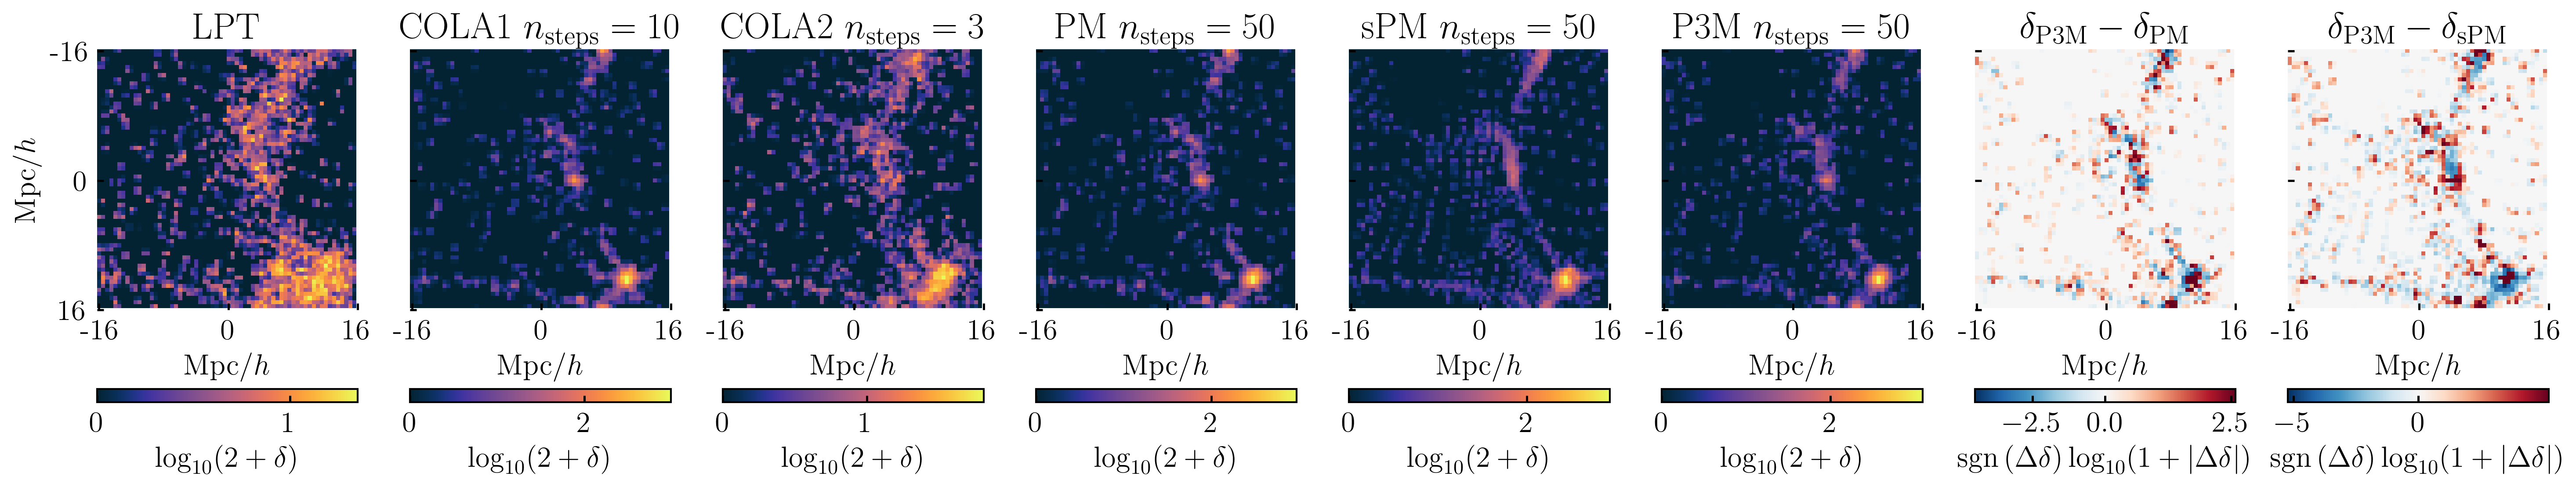

In [13]:
# fields = ["pm", "spm", "p3m", "diff_p3m_pm"]  # fields to plot
fields = ["lpt", "cola1", "cola2", "pm", "spm", "p3m", "diff_p3m_pm", "diff_p3m_spm"]  # fields to plot

figname = "_".join(fields)
slices_dict = {
    "lpt": DELTA_LPT,
    "cola1": DELTA_COLA1,
    "cola2": DELTA_COLA2,
    "pm": DELTA_PM,
    "spm": DELTA_SPM,
    "p3m": DELTA_P3M,
    "diff_p3m_pm": diff_p3m_pm,
    "diff_p3m_spm": diff_p3m_spm,
}
titles_dict = {
    "lpt": "LPT",
    "cola1": f"COLA1 $n_\\mathrm{{steps}}={nsteps_cola1}$",
    "cola2": f"COLA2 $n_\\mathrm{{steps}}={nsteps_cola2}$",
    "pm": f"PM $n_\\mathrm{{steps}}={nsteps_pm}$",
    "spm": f"sPM $n_\\mathrm{{steps}}={nsteps_spm}$",
    "p3m": f"P3M $n_\\mathrm{{steps}}={nsteps_p3m}$",
    "diff_p3m_pm": r"$\delta_{\rm P3M}-\delta_{\rm PM}$",
    "diff_p3m_spm": r"$\delta_{\rm P3M}-\delta_{\rm sPM}$",
}

npanels = len(fields)
fig, axs = plt.subplots(1, npanels, figsize=(3 * npanels, 4), sharey=True)

ims = []
for i, key in enumerate(fields):
    ax = axs[i]
    data = slices_dict[key]
    title = titles_dict[key]

    if key.startswith("diff"):
        norm = TwoSlopeNorm(vmin=-np.log(1 + np.abs(np.min(data))), vcenter=0, vmax=np.log10(1 + np.abs(np.max(data))))
        im = ax.imshow(
            np.sign(data) * np.log(1 + np.abs(data)), cmap="RdBu_r", norm=norm
        )
    else:
        im = ax.imshow(np.log10(2 + data), cmap=cmap)

    ims.append((im, key))
    ax.set_title(title, fontsize=fs_titles)
    for spine in ax.spines.values():
        spine.set_visible(False)

axs[0].set_yticks([0, N // 2, N])
axs[0].set_yticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
axs[0].set_ylabel(r"Mpc/$h$", size=GLOBAL_FS_SMALL)

for i, ax in enumerate(axs):
    ax.set_xticks([0, N // 2, N])
    ax.set_xticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
    ax.set_xlabel(r"Mpc/$h$", size=GLOBAL_FS_SMALL)

for ax, (im, key) in zip(axs, ims):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    if key.startswith("diff"):
        cb.set_label(r"$\textrm{sgn}\left(\Delta\delta\right)\log_{10}(1 + |\Delta\delta|)$", fontsize=fs)
    else:
        cb.set_label(r"$\log_{10}(2 + \delta)$", fontsize=fs)
    cb.ax.tick_params(labelsize=fs)
    cax.xaxis.set_ticks_position("bottom")
    cax.xaxis.set_label_position("bottom")
fig.savefig(
    simdir + f"{figname}.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)
fig.savefig(
    simdir + f"{figname}.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

In [14]:
full_field_p3m = np.log10(2+read_field(simdir + f"nsteps{nsteps_p3m}_final_density_p3m.h5").data)

if N <= 128:
    fig = plotly_3d(full_field_p3m, size=N, L=L, colormap=thermal_plotly, limits="default")
else:
    # Downsample the grid for visualisation
    downsample_factor = N // 128
    downsampled_field = full_field_p3m[
        ::downsample_factor, ::downsample_factor, ::downsample_factor
    ]
    fig = plotly_3d(downsampled_field, size=N, L=L, colormap=thermal_plotly, limits="default")

fig.show()
clear_large_plot(fig)  # Uncomment to clear the Plotly figure to avoid memory issues

### Compute and plot the power spectra of the evolved dark matter fields

In [15]:
G = read_FourierGrid(simdir + "input_ss_k_grid.h5")
k = G.k_modes[1:]
AliasingCorr = False

DELTA = read_field(simdir + "initial_density.h5")
Pk_INI, Vk_INI = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_INI, Vk_INI = Pk_INI[1:], Vk_INI[1:]
Sk_INI = np.sqrt(Vk_INI)

DELTA = read_field(simdir + "lpt_density.h5")
Pk_LPT, Vk_LPT = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_LPT, Vk_LPT = Pk_LPT[1:], Vk_LPT[1:]
Sk_LPT = np.sqrt(Vk_LPT)

DELTA = read_field(simdir + f"nsteps{nsteps_pm}_final_density_pm.h5")
Pk_PM, Vk_PM = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_PM, Vk_PM = Pk_PM[1:], Vk_PM[1:]
Sk_PM = np.sqrt(Vk_PM)

DELTA = read_field(simdir + f"nsteps{nsteps_cola1}_final_density_cola.h5")
Pk_COLA1, Vk_COLA1 = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_COLA1, Vk_COLA1 = Pk_COLA1[1:], Vk_COLA1[1:]
Sk_COLA1 = np.sqrt(Vk_COLA1)

DELTA = read_field(simdir + f"nsteps{nsteps_cola2}_final_density_cola.h5")
Pk_COLA2, Vk_COLA2 = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_COLA2, Vk_COLA2 = Pk_COLA2[1:], Vk_COLA2[1:]
Sk_COLA2 = np.sqrt(Vk_COLA2)

DELTA = read_field(simdir + f"nsteps{nsteps_spm}_final_density_spm.h5")
Pk_sPM, Vk_sPM = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_sPM, Vk_sPM = Pk_sPM[1:], Vk_sPM[1:]
Sk_sPM = np.sqrt(Vk_sPM)

DELTA = read_field(simdir + f"nsteps{nsteps_p3m}_final_density_p3m.h5")
Pk_P3M, Vk_p3m = get_autocorrelation(DELTA, G, AliasingCorr)
Pk_P3M, Vk_p3m = Pk_P3M[1:], Vk_p3m[1:]
Sk_p3m = np.sqrt(Vk_p3m)

[00:54:55|STATUS    ]|Read Fourier grid in data file '/Users/hoellinger/WIP3M/notebook1/input_ss_k_grid.h5'...
[00:54:55|DIAGNOSTIC]==|L0=32.0, L1=32.0, L2=32.0
[00:54:55|DIAGNOSTIC]==|N0=64, N1=64, N2=64, N2_HC=33, N_HC=135168, NUM_MODES=51
[00:54:55|STATUS    ]|Read Fourier grid in data file '/Users/hoellinger/WIP3M/notebook1/input_ss_k_grid.h5' done.
[00:54:55|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook1/initial_density.h5'...
[00:54:55|DIAGNOSTIC]==|ranges=[np.float64(-16.0), np.float64(16.0), np.float64(-16.0), np.float64(16.0), np.float64(-16.0), np.float64(16.0), np.int32(64), np.int32(64), np.int32(64)]
[00:54:55|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook1/initial_density.h5' done.
[00:54:55|STATUS    ]|Getting auto-correlation in Fourier space (using 8 cores)...
[00:54:55|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook1/lpt_density.h5'...
[00:54:55|STATUS    ]|Getting auto-correlation in Fourier space (

kmin = 0.6722924113273621, kmax = 10.397425651550293


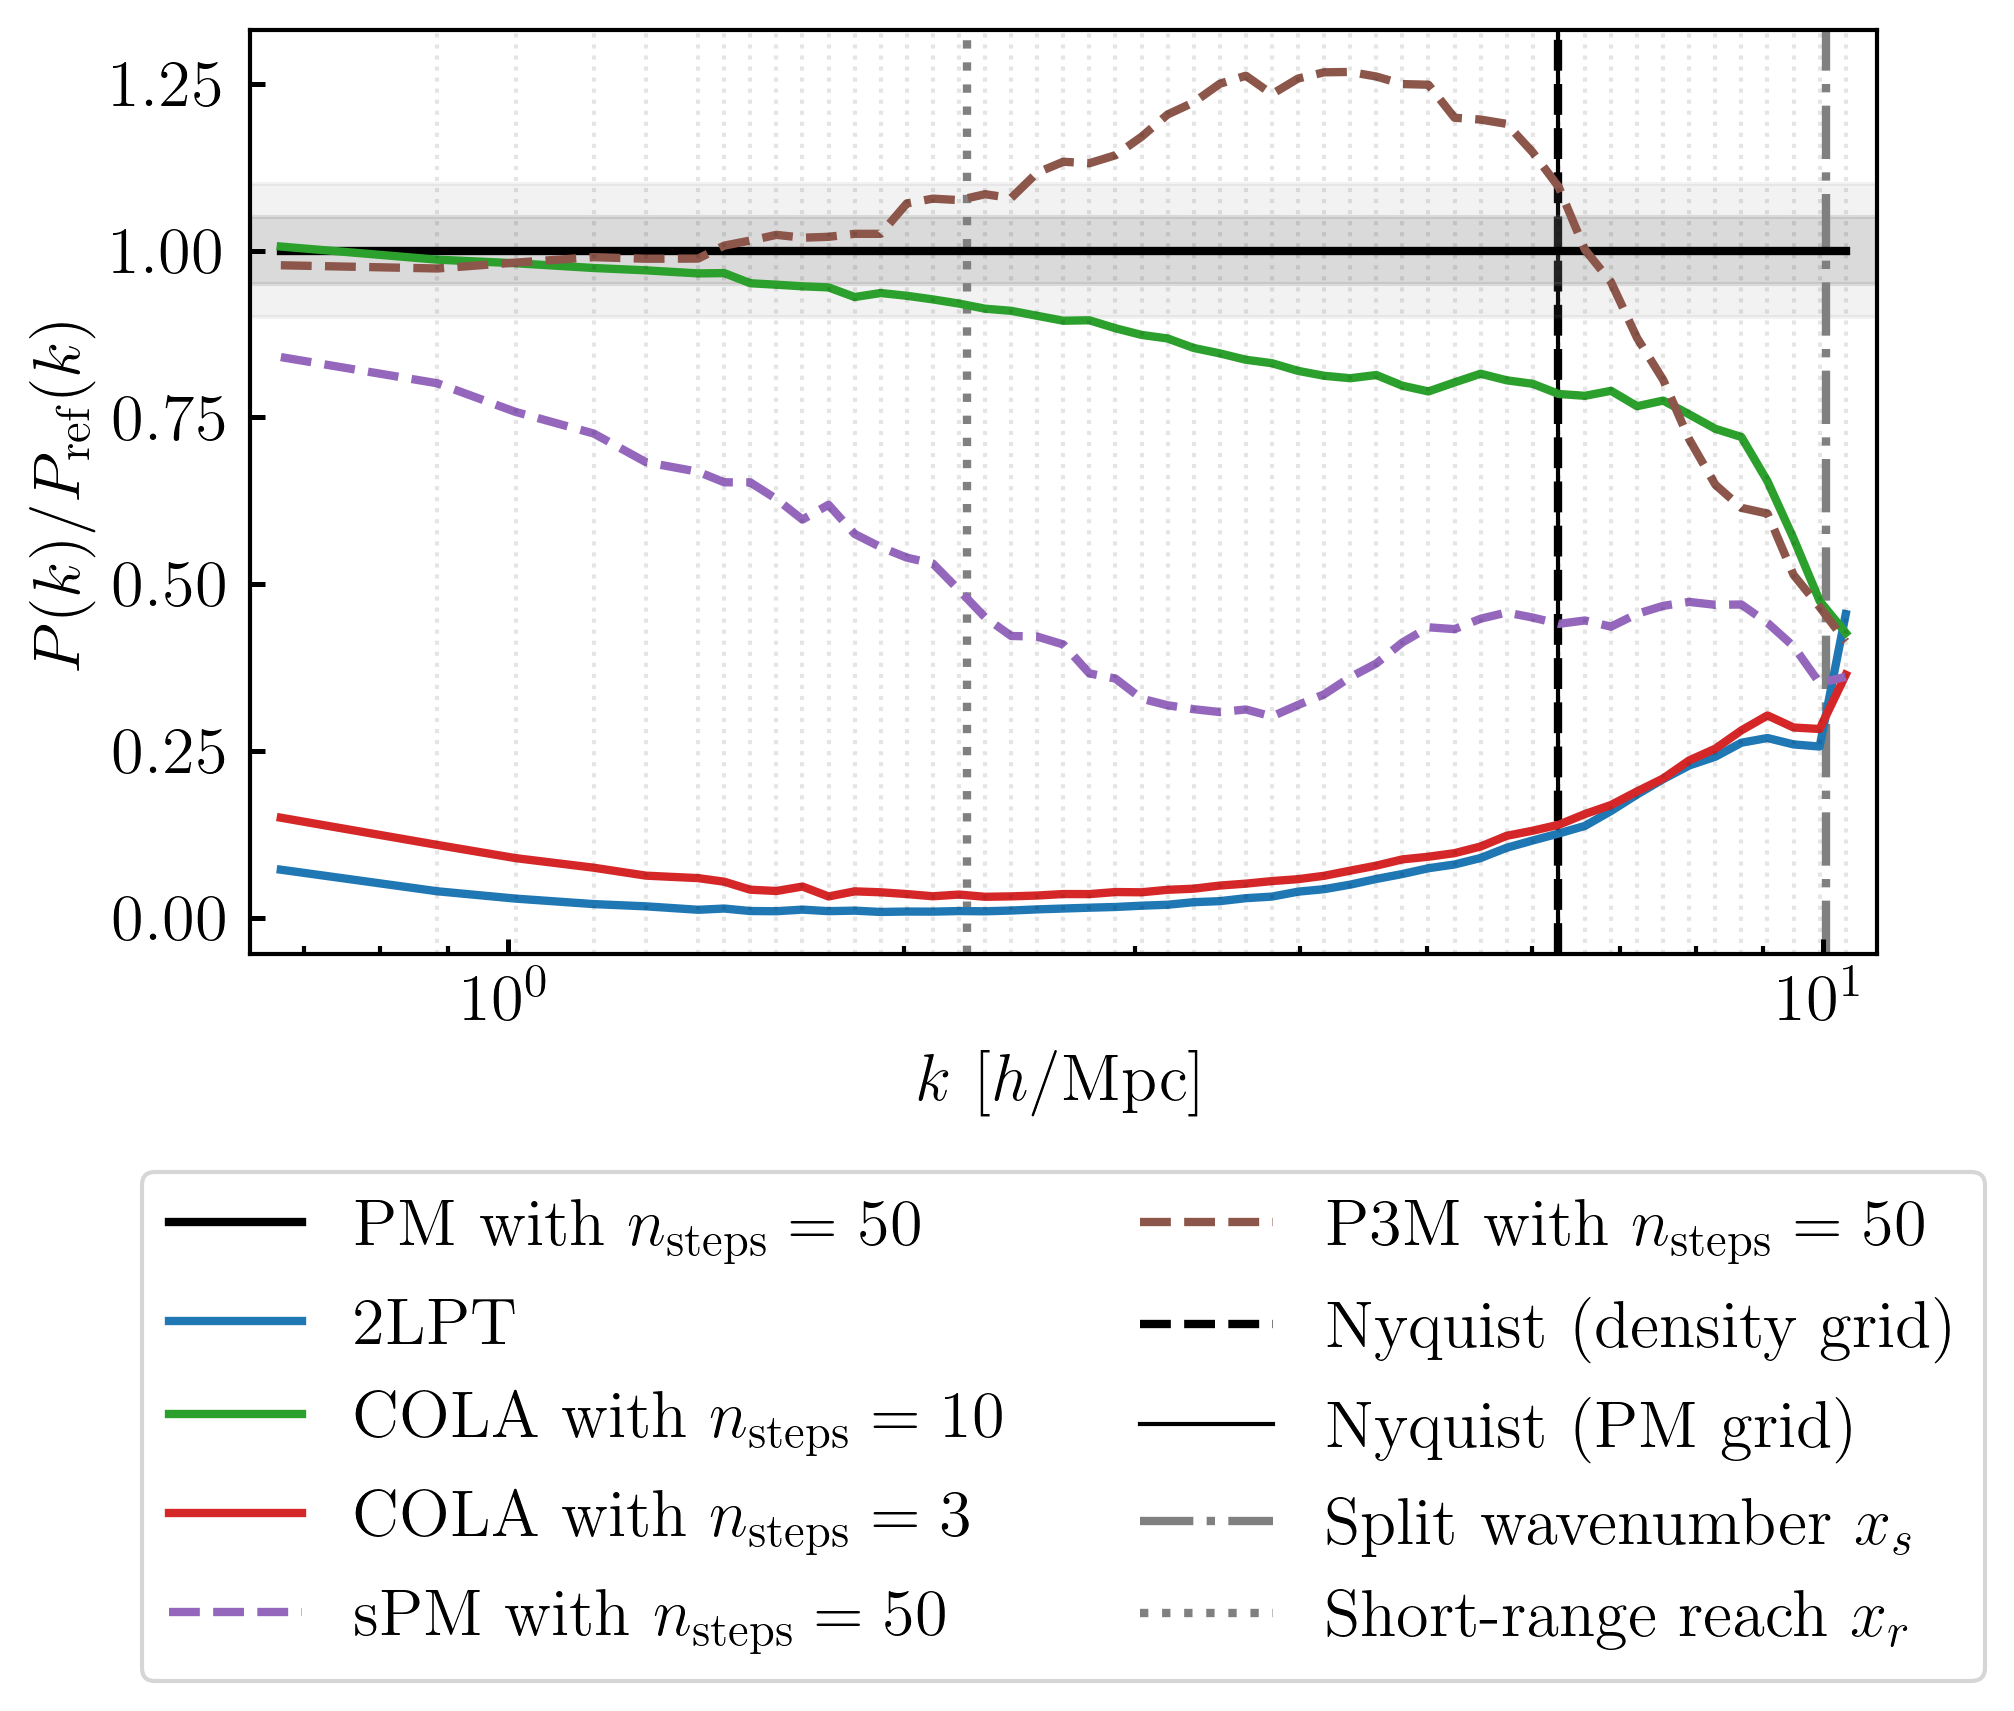

In [16]:
Pk_ref = Pk_PM

fig, ax = plt.subplots(figsize=(7, 4))

ax.set_xscale("log")
k = G.k_modes[1:]
kmin, kmax = k.min(), k.max()
print(f"kmin = {kmin}, kmax = {kmax}")
log_pad = 0.02
log_k_min = np.log10(kmin)
log_k_max = np.log10(kmax)
log_range = log_k_max - log_k_min
xlim_min = 10 ** (log_k_min - log_pad * log_range)
xlim_max = 10 ** (log_k_max + log_pad * log_range)

plt.xlim(xlim_min, xlim_max)
# ax.set_ylim([0.2, 1.8])
# ax.set_ylim([0.5, 1.5])
dark_grey_bnd = 0.05
light_grey_bnd = 0.1

label_ref = f"PM with $n_\\mathrm{{steps}}={nsteps_pm}$"

line1 = ax.plot([kmin, kmax], [1, 1], color="black", linestyle="-", label=label_ref)

line2 = ax.plot(k, Pk_LPT / Pk_ref, label="2LPT", color=cols[0], linestyle="-")

ax.plot(
    k,
    Pk_COLA1 / Pk_ref,
    label=f"COLA with $n_\\mathrm{{steps}}={nsteps_cola1}$",
    linestyle="-",
    color=cols[2],
)
ax.plot(
    k,
    Pk_COLA2 / Pk_ref,
    label=f"COLA with $n_\\mathrm{{steps}}={nsteps_cola2}$",
    linestyle="-",
    color=cols[3],
)
ax.plot(
    k,
    Pk_sPM / Pk_ref,
    label=f"sPM with $n_\\mathrm{{steps}}={nsteps_p3m}$",
    linestyle="--",
    color=cols[4],
)
ax.plot(
    k,
    Pk_P3M / Pk_ref,
    label=f"P3M with $n_\\mathrm{{steps}}={nsteps_p3m}$",
    linestyle="--",
    color=cols[5],
)

ax.axhspan(1 - dark_grey_bnd, 1 + dark_grey_bnd, color="grey", alpha=0.2)
ax.axhspan(1 - light_grey_bnd, 1 + light_grey_bnd, color="grey", alpha=0.1)

for i in range(1, len(k)):
    ax.axvline(k[i], color="black", linestyle=":", linewidth=1, alpha=0.1)
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
ax.set_xlabel("$k$ [$h/\\mathrm{Mpc}$]", fontsize=fs)
ax.set_ylabel("$P(k)/P_\\mathrm{ref}(k)$", fontsize=fs)
ax.tick_params(which="both", direction="in")
ax.tick_params(axis="both", which="major", labelsize=fs)
ax.tick_params(axis="both", which="minor", labelsize=fs)

# Characteristic vertical reference scales
nyquist = np.pi * N / L
nyquist_PM = np.pi * Npm / L
epsilon = 0.03 * L / Np
particle_length = 2 * epsilon
xs = 1.25 * L / Npm
xr = 4.5 * xs
particle_wavenumber = 2 * np.pi / particle_length  # Too large to be shown
xs_inv = 2 * np.pi / xs
xr_inv = 2 * np.pi / xr
if nyquist <= xlim_max:
    line1 = ax.axvline(
        x=nyquist, color="black", linestyle="--", lw=2, label="Nyquist (density grid)", zorder=0
    )
if nyquist_PM <= xlim_max:
    line2 = ax.axvline(
        x=nyquist_PM, color="black", linestyle="-", lw=1, label="Nyquist (PM grid)", zorder=0
    )
if xs_inv <= xlim_max:
    line3 = ax.axvline(
        x=xs_inv, color="gray", linestyle="-.", lw=2, label=r"Split wavenumber $x_s$", zorder=0
    )
if xr_inv <= xlim_max:
    line4 = ax.axvline(
        x=xr_inv, color="gray", linestyle=":", lw=2, label=r"Short-range reach $x_r$", zorder=0
    )

empty_patch = mpatches.Patch(color="none", label="")
handles, labels = plt.gca().get_legend_handles_labels()
# handles = [empty_patch, *handles]
# labels = ["", *labels]
plt.legend(
    handles,
    labels,
    loc="upper center",
    ncol=2,
    bbox_to_anchor=(0.5, -0.2),
    fontsize=fs,
)
fig.savefig(
    simdir + "power_spectrum.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)
fig.savefig(
    simdir + "power_spectrum.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

### Force exerted by particles on other particles

Newton prefactor = 7.96e-02
Nyquist: 1.00 Mpc/h
Particle length: 0.06 Mpc/h
Split scale: 0.62 Mpc/h
Short-range reach: 2.81 Mpc/h
Figure saved to: /Users/hoellinger/WIP3M/notebook1/force_diagnostic_comparison.png


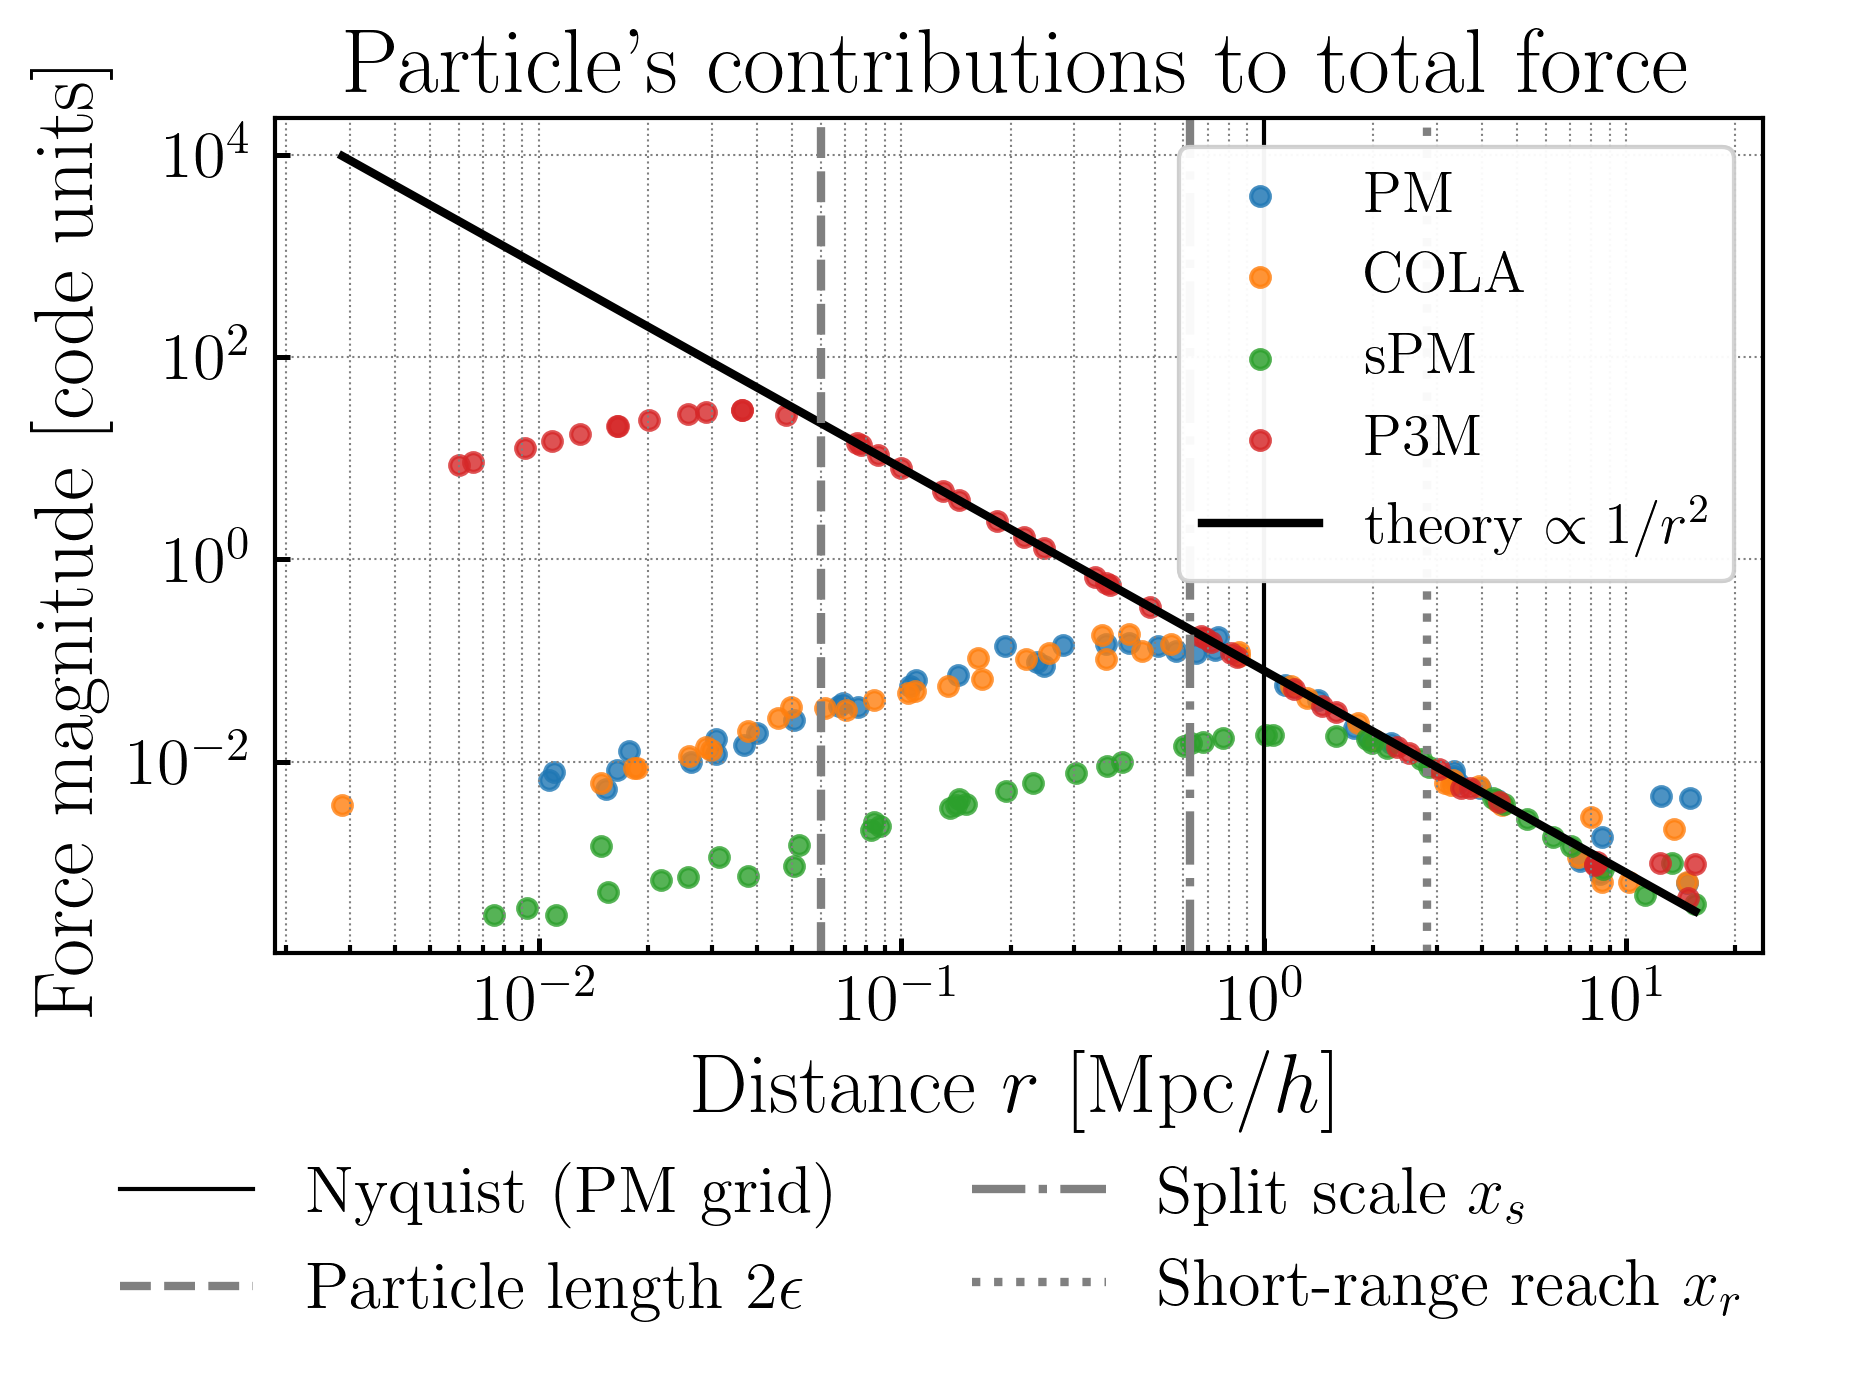

In [17]:
r1, fmag1, _ = load_force_diagnostic(OutputForceDiagnostic_pm)
r4, fmag4, _ = load_force_diagnostic(OutputForceDiagnostic_cola1)
r2, fmag2, _ = load_force_diagnostic(OutputForceDiagnostic_spm)
r3, fmag3, _ = load_force_diagnostic(OutputForceDiagnostic_p3m)

rr = np.array([r1, r4, r2, r3], dtype=object)
ff = np.array([fmag1, fmag4, fmag2, fmag3], dtype=object)
ll = np.array(["PM", "COLA", "sPM", "P3M"])

ix = [0, 1, 2, 3]

Newton_prefactor = (L / Np)**3 / (4*np.pi)
print(f"Newton prefactor = {Newton_prefactor:.2e}")
plot_force_distance_comparison(rr=rr[ix], ff=ff[ix], ll=ll[ix], L=L, Np=Np, Npm=Npm, a=Newton_prefactor, title="Particle's contributions to total force", save_path=simdir + "force_diagnostic_comparison.png")